<a href="https://colab.research.google.com/github/ptl-harsh/DL_Lab/blob/main/DL_Lab_03_28_August.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Design and implement an Image classification model to classify a dataset of images using Deep Feed Forward NN. Record the accuracy corresponding to the number of epochs. Use the MNIST, CIFAR-10 datasets.

In [1]:
# ============================================================
# Deep Feed Forward (MLP) Image Classifiers for MNIST & CIFAR-10
# - Trains separate MLPs on MNIST and CIFAR-10 (no CNNs)
# - Records train/val accuracy per epoch
# - Plots accuracy curves and saves CSV logs
# ============================================================

In [2]:
import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# ------------- Reproducibility -------------
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
# ------------- Hyperparameters -------------
BATCH_SIZE = 256
EPOCHS_MNIST = 10
EPOCHS_CIFAR = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
DROPOUT = 0.2

# Hidden layer sizes for deep MLP (>= 4 hidden layers)
HIDDEN_MNIST = [512, 512, 256, 256, 128]   # input 784
HIDDEN_CIFAR = [1024, 1024, 512, 512, 256] # input 3072

In [5]:

# ------------- Data -------------
# MNIST normalization (mean/std from dataset)
tf_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# CIFAR-10 normalization (standard)
tf_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

def get_loaders(dataset_name: str, batch_size: int = 256):
    if dataset_name.upper() == "MNIST":
        train_set = datasets.MNIST(root="./data", train=True, download=True, transform=tf_mnist)
        test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=tf_mnist)
        in_dim, n_classes = 28*28, 10
    elif dataset_name.upper() == "CIFAR10":
        train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=tf_cifar)
        test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=tf_cifar)
        in_dim, n_classes = 32*32*3, 10
    else:
        raise ValueError("Unknown dataset. Use 'MNIST' or 'CIFAR10'.")

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, in_dim, n_classes

In [6]:
# ------------- Model -------------
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims, num_classes: int, dropout: float = 0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(prev, h),
                nn.BatchNorm1d(h),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            ]
            prev = h
        layers += [nn.Linear(prev, num_classes)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # flatten (N, C, H, W) -> (N, CHW)
        x = x.view(x.size(0), -1)
        return self.net(x)


In [7]:
# ------------- Training Utils -------------
@torch.no_grad()
def accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return correct / total

def train_one_epoch(model, loader, criterion, optimizer, device, grad_clip=1.0):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item() * yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    train_loss = running_loss / total
    train_acc  = correct / total
    return train_loss, train_acc

def fit(dataset_name, hidden_dims, epochs, lr=1e-3, weight_decay=1e-4, dropout=0.2, batch_size=256):
    print(f"\n=== Training on {dataset_name} ===")
    train_loader, val_loader, input_dim, n_classes = get_loaders(dataset_name, batch_size)

    model = MLP(input_dim, hidden_dims, n_classes, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # mild LR decay
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(epochs//3, 1), gamma=0.5)

    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_acc": []}
    best_val, best_state = 0.0, None

    start = time.time()
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_acc = accuracy(model, val_loader, device)
        scheduler.step()

        history["epoch"].append(ep)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        if va_acc > best_val:
            best_val = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"Epoch {ep:02d}: loss={tr_loss:.4f} | train_acc={tr_acc*100:5.2f}% | val_acc={va_acc*100:5.2f}%")

    dur = time.time() - start
    print(f"Best Val Acc on {dataset_name}: {best_val*100:.2f}%  (time: {dur/60:.1f} min)")

    if best_state is not None:
        model.load_state_dict(best_state)

    df = pd.DataFrame(history)
    csv_name = f"{dataset_name.lower()}_mlp_history.csv"
    df.to_csv(csv_name, index=False)
    print(f"Saved log: {csv_name}")

    # Plot accuracy vs epochs
    plt.figure(figsize=(6,4))
    plt.plot(df["epoch"], df["train_acc"], label="Train Acc")
    plt.plot(df["epoch"], df["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{dataset_name} MLP Accuracy vs Epochs")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    png_name = f"{dataset_name.lower()}_mlp_accuracy.png"
    plt.savefig(png_name, dpi=150)
    plt.show()
    print(f"Saved plot: {png_name}")

    # Return everything useful
    return model, df


=== Training on MNIST ===


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]


Epoch 01: loss=0.3085 | train_acc=91.88% | val_acc=96.92%
Epoch 02: loss=0.1230 | train_acc=96.41% | val_acc=97.49%
Epoch 03: loss=0.0914 | train_acc=97.29% | val_acc=97.57%
Epoch 04: loss=0.0610 | train_acc=98.18% | val_acc=98.31%
Epoch 05: loss=0.0508 | train_acc=98.46% | val_acc=98.25%
Epoch 06: loss=0.0437 | train_acc=98.68% | val_acc=98.41%
Epoch 07: loss=0.0326 | train_acc=99.04% | val_acc=98.50%
Epoch 08: loss=0.0280 | train_acc=99.14% | val_acc=98.51%
Epoch 09: loss=0.0250 | train_acc=99.25% | val_acc=98.54%
Epoch 10: loss=0.0213 | train_acc=99.36% | val_acc=98.64%
Best Val Acc on MNIST: 98.64%  (time: 2.2 min)
Saved log: mnist_mlp_history.csv


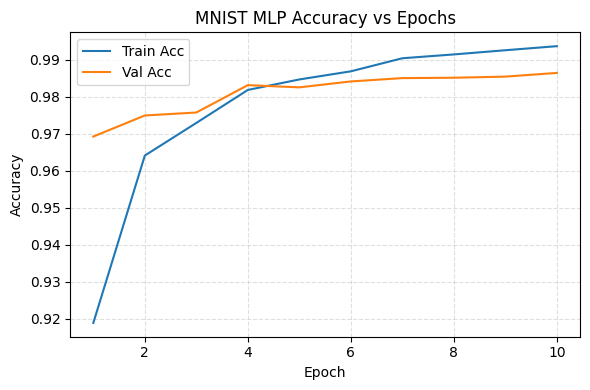

Saved plot: mnist_mlp_accuracy.png

=== Training on CIFAR10 ===


100%|██████████| 170M/170M [00:09<00:00, 17.1MB/s]


Epoch 01: loss=1.7010 | train_acc=38.77% | val_acc=45.63%
Epoch 02: loss=1.4649 | train_acc=47.68% | val_acc=50.38%
Epoch 03: loss=1.3630 | train_acc=51.53% | val_acc=51.80%
Epoch 04: loss=1.2886 | train_acc=54.18% | val_acc=53.36%
Epoch 05: loss=1.2340 | train_acc=56.27% | val_acc=54.00%
Epoch 06: loss=1.1783 | train_acc=58.20% | val_acc=55.11%
Epoch 07: loss=1.0684 | train_acc=62.29% | val_acc=56.98%
Epoch 08: loss=1.0158 | train_acc=64.31% | val_acc=56.60%
Epoch 09: loss=0.9785 | train_acc=65.36% | val_acc=57.52%
Epoch 10: loss=0.9388 | train_acc=66.80% | val_acc=57.43%
Epoch 11: loss=0.9079 | train_acc=67.86% | val_acc=57.35%
Epoch 12: loss=0.8710 | train_acc=69.32% | val_acc=58.17%
Epoch 13: loss=0.7761 | train_acc=72.69% | val_acc=59.01%
Epoch 14: loss=0.7387 | train_acc=74.22% | val_acc=58.70%
Epoch 15: loss=0.7044 | train_acc=75.15% | val_acc=58.98%
Epoch 16: loss=0.6833 | train_acc=75.86% | val_acc=58.91%
Epoch 17: loss=0.6616 | train_acc=76.91% | val_acc=58.47%
Epoch 18: loss

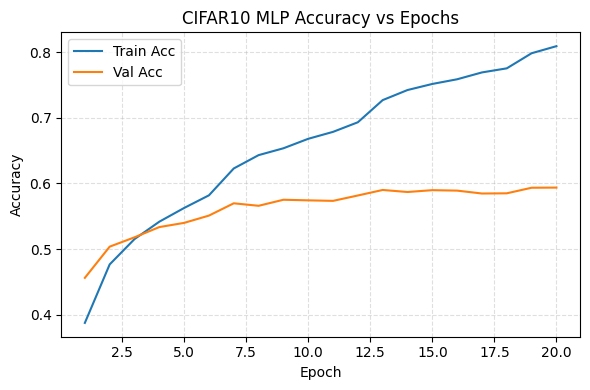

Saved plot: cifar10_mlp_accuracy.png


In [8]:
# ------------- Run: MNIST & CIFAR-10 -------------
mnist_model, mnist_hist = fit(
    dataset_name="MNIST",
    hidden_dims=HIDDEN_MNIST,
    epochs=EPOCHS_MNIST,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE
)

cifar_model, cifar_hist = fit(
    dataset_name="CIFAR10",
    hidden_dims=HIDDEN_CIFAR,
    epochs=EPOCHS_CIFAR,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE
)



Sample MNIST predictions:


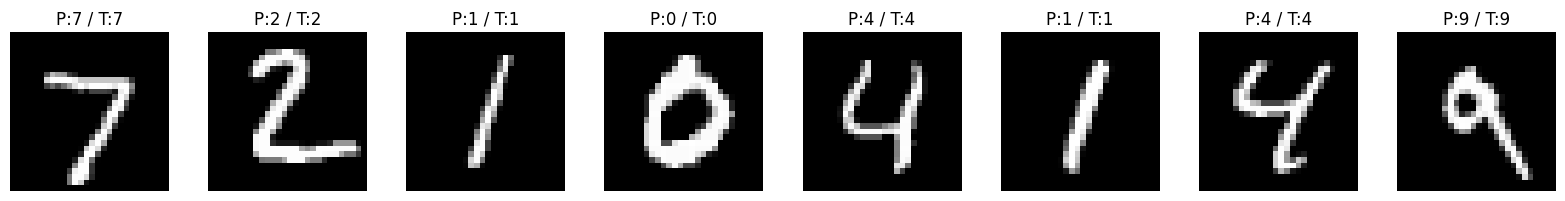


Sample CIFAR-10 predictions:


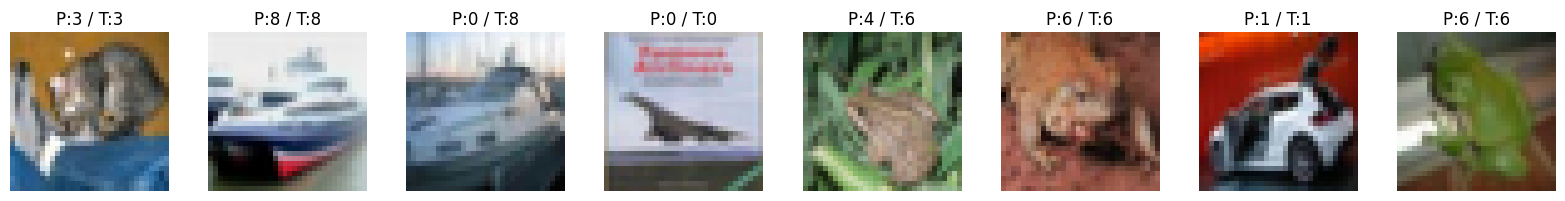

In [9]:
# ------------- Quick sample predictions -------------
@torch.no_grad()
def show_samples(model, dataset_name, n=8):
    model.eval()
    _, val_loader, _, _ = get_loaders(dataset_name, batch_size=n)
    xb, yb = next(iter(val_loader))
    logits = model(xb.to(device))
    pred = logits.argmax(dim=1).cpu().numpy()

    # prepare grid
    xb = xb.cpu()
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    if dataset_name.upper() == "MNIST":
        for i in range(n):
            axes[i].imshow(xb[i,0], cmap="gray")
            axes[i].set_title(f"P:{pred[i]} / T:{yb[i].item()}")
            axes[i].axis("off")
    else:
        # CIFAR is RGB
        for i in range(n):
            img = xb[i].permute(1,2,0).numpy()
            # de-normalize for display
            mean = np.array([0.4914, 0.4822, 0.4465])
            std  = np.array([0.2470, 0.2435, 0.2616])
            img = (img * std + mean).clip(0,1)
            axes[i].imshow(img)
            axes[i].set_title(f"P:{pred[i]} / T:{yb[i].item()}")
            axes[i].axis("off")
    plt.tight_layout()
    plt.show()

print("\nSample MNIST predictions:")
show_samples(mnist_model, "MNIST", n=8)

print("\nSample CIFAR-10 predictions:")
show_samples(cifar_model, "CIFAR10", n=8)